In [1]:
from dataloader import read_bci_data
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
torch.cuda.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# print(torch.__version__)
# print(torch.cuda.current_device())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))
# print(torch.cuda.is_available())

cuda


In [3]:
X_train, y_train, X_test, y_test = read_bci_data()
dataset_train = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4) #batch_size=256
dataset_test = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4) #batch_size=256
# print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [32]:
### EEGNet

In [4]:
class EEGNet(nn.Module):
    def __init__(self, activation=nn.ELU()):
        super().__init__()
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self,X):
        out = self.firstconv(X)
        out = self.depthwiseConv(out)
        out = self.seperableConv(out)     
        out = out.view(out.shape[0], -1) 
        out = self.classify(out)
        return out
    

In [12]:
### DeepConvNet

In [13]:
class DeepConvNet(nn.Module):
    def __init__(self, activation=nn.ELU()):
        super().__init__()
        
        self.conv0 = nn.Conv2d(1, 25, kernel_size=(1,5))
        self.conv1 = nn.Sequential(
            nn.Conv2d(25, 25, kernel_size=(2,1)),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            activation,
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1,5)),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            activation,
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1,5)),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            activation,
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1,5)),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            activation,
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )        
        self.classify = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(8600, 2),
            #nn.Softmax()
        )
        
    def forward(self,X):
        out = self.conv0(X)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.shape[0], -1)
        out = self.classify(out)
        return out
    

In [6]:
def evaluate(model, loader_test, device):
    model.eval()
    acc = 0
    
    for idx,(data,target) in enumerate(loader_test):
        data = data.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.long)
        predict = model(data)
        acc += predict.max(dim=1)[1].eq(target).sum().item()
    
    acc = 100.*acc/len(loader_test.dataset)
    return acc


In [7]:
def train_with_different_activation(loader_train, loader_test, activations, lr, epochs, device, net):
    Loss = nn.CrossEntropyLoss()
    df = pd.DataFrame()
    df_loss = pd.DataFrame()
    df['epoch'] = range(1, epochs+1)
    df_loss['epoch'] = range(1, epochs+1)
    best_model_wts = {'ReLU':None, 'LeakyReLU':None, 'ELU':None}
    best_evaluated_acc = {'ReLU':0, 'LeakyReLU':0, 'ELU':0}
    print(net)
    
    for name, activation in activations.items():
        print(name)
        if net == 'DeepConvNet':
            model=DeepConvNet(activation)
        elif net == 'EEGNet':
            model = EEGNet(activation)
            
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        loss_train = list()
        acc_train = list()
        acc_test = list()
        
        for epoch in range(1, epochs+1):
            ### Train
            model.train()
            total_loss = 0
            acc = 0            
            for idx,(data,target) in enumerate(loader_train):
                data = data.to(device, dtype=torch.float)
                target = target.to(device, dtype=torch.long) #target type has to be 'long'
                predict = model(data)
                loss = Loss(predict, target)
                total_loss += loss.item()
                acc += predict.max(dim=1)[1].eq(target).sum().item()           
                ### Update 
                optimizer.zero_grad()
                loss.backward()  
                optimizer.step()
                
            total_loss /= len(loader_train.dataset)
            acc = 100.*acc/len(loader_train.dataset)
            if epoch%10 == 0:
                print(f'epcoh{epoch:>3d}  loss:{total_loss:.4f}  acc:{acc:.1f}%')
            acc_train.append(acc)
            loss_train.append(total_loss)
            
            ### Test
            model.eval()
            acc = evaluate(model, loader_test, device)
            acc_test.append(acc)
            
            # update best model weights
            if acc>best_evaluated_acc[name]:
                best_evaluated_acc[name] = acc
                best_model_wts[name] = copy.deepcopy(model.state_dict())
                
        df[name + '_train'] = acc_train
        df[name + '_test'] = acc_test
        df_loss[name + '_loss'] = loss_train

    return df, df_loss, best_model_wts


In [8]:
def plot(dataframe, net, loss=False):
    fig = plt.figure(figsize=(10,6))
    
    for name in dataframe.columns[1:]:
        plt.plot('epoch', name, data=dataframe)
    plt.xlabel("Epoch")
    if loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy (%)")
    plt.legend()
    if net == 'DeepConvNet':
         plt.title("Activation function comparision (DeepConvNet)")
    elif net == 'EEGNet':
        plt.title("Activation function comparision (EEGNet)")
    
    return fig


In [39]:
### DeepConvNet

In [40]:
lr = 0.001 
epochs = 300
activations = {'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
df, df_loss, best_model_wts = train_with_different_activation(loader_train, loader_test, activations, lr, epochs, device, 'DeepConvNet') 
for name, model_wts in best_model_wts.items():
    torch.save(model_wts, os.path.join('deepconvnet models', name+'.pt'))

DeepConvNet
ReLU
epcoh 10  loss:0.0079  acc:75.0%
epcoh 20  loss:0.0069  acc:80.1%
epcoh 30  loss:0.0066  acc:80.6%
epcoh 40  loss:0.0060  acc:83.0%
epcoh 50  loss:0.0057  acc:83.8%
epcoh 60  loss:0.0055  acc:84.7%
epcoh 70  loss:0.0054  acc:85.5%
epcoh 80  loss:0.0049  acc:85.9%
epcoh 90  loss:0.0047  acc:87.3%
epcoh100  loss:0.0046  acc:88.1%
epcoh110  loss:0.0044  acc:88.8%
epcoh120  loss:0.0041  acc:88.7%
epcoh130  loss:0.0037  acc:91.2%
epcoh140  loss:0.0041  acc:88.9%
epcoh150  loss:0.0038  acc:90.3%
epcoh160  loss:0.0039  acc:90.3%
epcoh170  loss:0.0035  acc:91.4%
epcoh180  loss:0.0034  acc:90.4%
epcoh190  loss:0.0035  acc:91.9%
epcoh200  loss:0.0037  acc:89.7%
epcoh210  loss:0.0034  acc:91.9%
epcoh220  loss:0.0035  acc:91.0%
epcoh230  loss:0.0034  acc:91.0%
epcoh240  loss:0.0033  acc:92.3%
epcoh250  loss:0.0036  acc:90.4%
epcoh260  loss:0.0030  acc:91.6%
epcoh270  loss:0.0032  acc:91.3%
epcoh280  loss:0.0030  acc:92.7%
epcoh290  loss:0.0034  acc:90.6%
epcoh300  loss:0.0033  acc

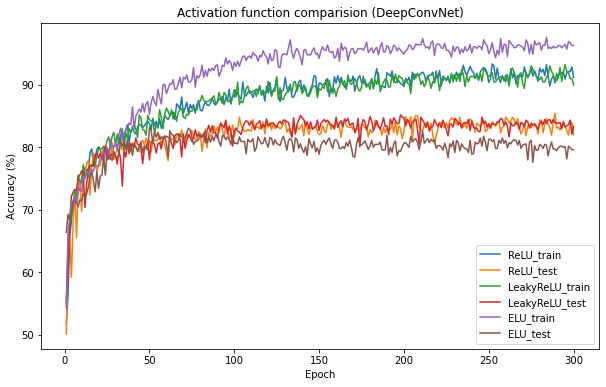

In [41]:
#df[-10:]
figure = plot(df, 'DeepConvNet')

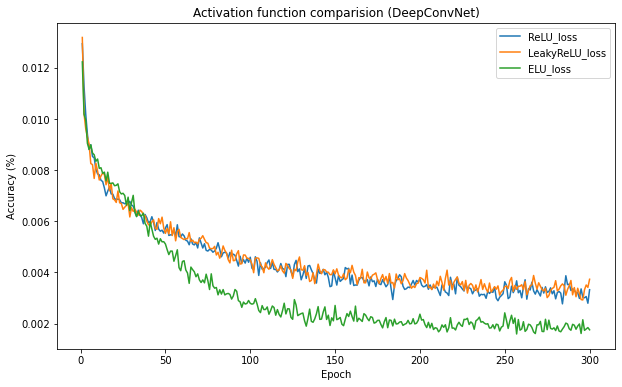

In [42]:
#df_loss[-10:]
figure = plot(df_loss, 'DeepConvNet', True)

In [43]:
for column in df.columns[1:]:
    print(f'{column:20}   max acc: {df[column].max():.2f} %')

ReLU_train             max acc: 93.33 %
ReLU_test              max acc: 85.46 %
LeakyReLU_train        max acc: 93.24 %
LeakyReLU_test         max acc: 85.19 %
ELU_train              max acc: 97.59 %
ELU_test               max acc: 83.15 %


In [ ]:
### EEGNet

In [24]:
lr = 0.001
epochs = 300
activations = {'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
df, df_loss, best_model_wts = train_with_different_activation(loader_train, loader_test, activations, lr, epochs, device, 'EEGNet')
for name, model_wts in best_model_wts.items():
    torch.save(model_wts, os.path.join('EEGnet models', name+'.pt'))

EEGNet
ReLU
epcoh 10  loss:0.0071  acc:78.8%
epcoh 20  loss:0.0056  acc:85.0%
epcoh 30  loss:0.0046  acc:88.0%
epcoh 40  loss:0.0039  acc:90.3%
epcoh 50  loss:0.0034  acc:91.2%
epcoh 60  loss:0.0030  acc:93.7%
epcoh 70  loss:0.0034  acc:90.6%
epcoh 80  loss:0.0028  acc:93.6%
epcoh 90  loss:0.0026  acc:93.9%
epcoh100  loss:0.0025  acc:94.3%
epcoh110  loss:0.0023  acc:95.1%
epcoh120  loss:0.0024  acc:94.6%
epcoh130  loss:0.0022  acc:95.8%
epcoh140  loss:0.0021  acc:95.4%
epcoh150  loss:0.0021  acc:95.3%
epcoh160  loss:0.0022  acc:94.4%
epcoh170  loss:0.0020  acc:96.4%
epcoh180  loss:0.0021  acc:95.5%
epcoh190  loss:0.0019  acc:96.3%
epcoh200  loss:0.0022  acc:95.4%
epcoh210  loss:0.0020  acc:96.5%
epcoh220  loss:0.0020  acc:96.3%
epcoh230  loss:0.0021  acc:95.8%
epcoh240  loss:0.0019  acc:96.0%
epcoh250  loss:0.0018  acc:97.0%
epcoh260  loss:0.0017  acc:96.9%
epcoh270  loss:0.0019  acc:96.5%
epcoh280  loss:0.0018  acc:96.5%
epcoh290  loss:0.0019  acc:96.3%
epcoh300  loss:0.0018  acc:96.4

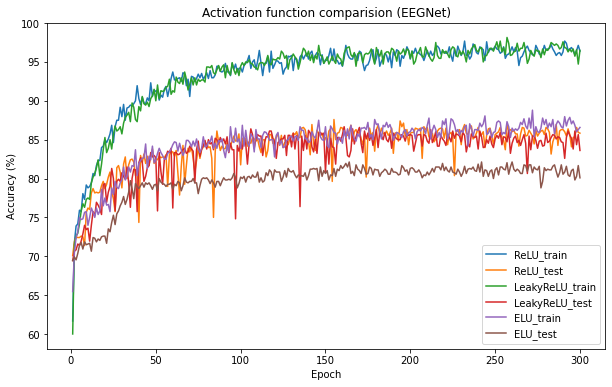

In [25]:
#df[-10:]
figure = plot(df, 'EEGNet')

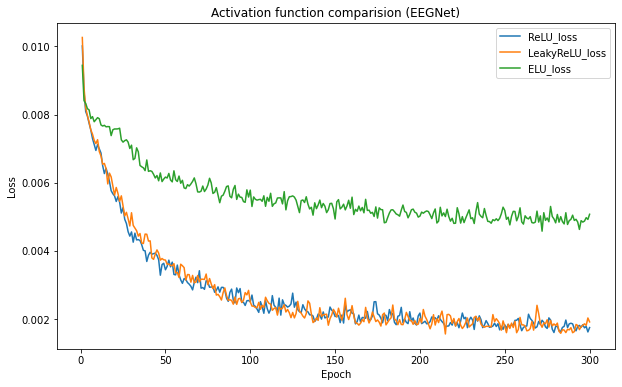

In [26]:
#df_loss[-10:]
figure = plot(df_loss, 'EEGNet', True)

In [27]:
for column in df.columns[1:]:
    print(f'{column:20}   max acc: {df[column].max():.2f} %')

ReLU_train             max acc: 97.69 %
ReLU_test              max acc: 87.59 %
LeakyReLU_train        max acc: 98.15 %
LeakyReLU_test         max acc: 86.67 %
ELU_train              max acc: 88.80 %
ELU_test               max acc: 82.13 %


In [ ]:
### Demo

In [8]:
_,_,X_test,y_test = read_bci_data()
dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
loader_test = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
model = EEGNet(nn.LeakyReLU())
model.load_state_dict(torch.load(os.path.join('EEGnet models','ReLU.pt')))
model.to(device)
acc = evaluate(model, loader_test, device)
print(f'accuracy: {acc:.2f}%')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
accuracy: 87.78%
